## Combines a triplet loss with a standard binary cross-entropy loss

Similar to the method used in <i>Accurate Sentence Matching with Hybrid Siamese Networks</i>. Task is the predict whether the description of a problem indicates it is a big or small concern.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Embedding,LSTM,Bidirectional,Input,Dense,Concatenate,GlobalMaxPool1D,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.metrics import f1_score,accuracy_score,balanced_accuracy_score
from sklearn.utils import shuffle
import ast
import time
import random
from utils import get_train_test_split,plot_pca

In [2]:
cdf = pd.read_csv("../data/cleaned_data.csv")
y = cdf['how_big_of_concern_is_problem'].copy(deep=True).tolist()
cdf['problem_tokens_int'] = cdf['problem_tokens_int'].apply(lambda list_string: ast.literal_eval(list_string))
old_x = cdf['problem_tokens_int'].copy(deep=True).tolist()

In [3]:
# updating x based on the padding length
padding_length = 40
x = []
for row in old_x:
    x.append((row+[0 for _ in range(padding_length)])[:padding_length])
x = np.array(x).astype("int32")
y = np.array(y)
y = np.expand_dims(y,axis=-1)
print(x.shape,y.shape)

(63046, 40) (63046, 1)


In [4]:
x_train,x_test,y_train,y_test = get_train_test_split(x,y)
y_train = np.squeeze(y_train,axis=-1)
y_test = np.squeeze(y_test,axis=-1)
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(60000, 40) (60000,) (3046, 40) (3046,)


In [5]:
# loading in the pretrained word embeddings
embedding_matrix = np.load("../data/embeddings.npy")
print(embedding_matrix.shape)

(16407, 300)


In [6]:
# getting the indices for all of the examples - used later for sampling the positive and negative examples per anchor
indices = np.array([i for i in range(len(y_train))])
print(len(indices))

60000


### Utils

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def get_train_test_split(x,y,num_per_class=1523,random_state=5):
    """ returns train_test_split which has an equal number of both classes in the test set
        -assumes that there are only two classes
        -num_per_class is set so that there are 60k training examples
    """

    if len(y.shape)==2:
        y_bool = np.squeeze(y)
    else:
        y_bool = y

    x_0 = x[y_bool==0]
    x_1 = x[y_bool==1]
    y_0 = y[y_bool==0]
    y_1 = y[y_bool==1]

    x_0,y_0 = shuffle(x_0,y_0,random_state=random_state)
    x_1,y_1 = shuffle(x_1,y_1,random_state=random_state)

    start0 = len(x_0)-num_per_class
    x_train0,x_test0, y_train0,y_test0 = x_0[:start0],x_0[start0:], y_0[:start0],y_0[start0:]
    start1 = len(x_1)-num_per_class
    x_train1,x_test1, y_train1,y_test1 = x_1[:start1],x_1[start1:], y_1[:start1],y_1[start1:]

    x_train = np.vstack([x_train0,x_train1])
    x_test = np.vstack([x_test0,x_test1])
    y_train = np.vstack([y_train0,y_train1])
    y_test = np.vstack([y_test0,y_test1])

    x_train,y_train = shuffle(x_train,y_train,random_state=random_state)
    x_test,y_test = shuffle(x_test,y_test,random_state=random_state)

    return x_train,x_test,y_train,y_test


def plot_pca(x_train,y_train,x_test,y_test):
    all_values = np.vstack([x_train,x_test])
    pca = PCA(n_components=2)
    plot_vectors = pca.fit_transform(all_values)
    x_train_reduced = plot_vectors[:len(x_train)]
    x_test_reduced = plot_vectors[len(x_train):]

    x_train_reduced_0 = x_train_reduced[y_train==0]
    x_train_reduced_1 = x_train_reduced[y_train==1]
    assert(len(x_train_reduced_0)+len(x_train_reduced_1)==len(x_train_reduced))
    x_test_reduced_0 = x_test_reduced[y_test==0]
    x_test_reduced_1 = x_test_reduced[y_test==1]
    assert(len(x_test_reduced_0)+len(x_test_reduced_1)==len(x_test_reduced))

    plt.scatter(x_train_reduced_0[:,0],x_train_reduced_0[:,1],c="gray",alpha=0.5)
    plt.scatter(x_test_reduced_0[:,0],x_test_reduced_0[:,1],c="black")
    plt.scatter(x_train_reduced_1[:,0],x_train_reduced_1[:,1],c="cyan",alpha=0.5)
    plt.scatter(x_test_reduced_1[:,0],x_test_reduced_1[:,1],c="blue")
    plt.show()

### Model

In [7]:
def network(embedding_layer,input_len=40):
    """ forward pass of the combined RNN/Siamese network
    """
    x = Input(shape=(input_len),dtype=tf.int32)
    input_e = embedding_layer(x)
    h = LSTM(units=256,activation="tanh",return_sequences=False)(input_e)
    h1 = Dense(256,activation="relu")(h)
    h2 = Dense(1,activation="sigmoid")(h1) # prediction for standard rnn model
    seq_emb = K.l2_normalize(h1,axis=-1) # embedding for use in siamese network
    
    model = Model(inputs=[x],outputs=[h2,seq_emb])
    return model

In [8]:
def triplet_loss(anchor_emb,pos_emb,neg_emb,alpha):
    """ 
    """
    anchor_pos_dist = tf.reduce_sum(tf.square(anchor_emb-pos_emb),axis=-1) # euclid dist.
    anchor_neg_dist = tf.reduce_sum(tf.square(anchor_emb-neg_emb),axis=-1)
    loss = tf.reduce_mean(tf.maximum(anchor_pos_dist-anchor_neg_dist+alpha,0.0))
    return loss

In [9]:
def combined_loss(y_true,y_pred,anchor_emb,pos_emb,neg_emb,triplet_loss_contrib,alpha=0.5):
    """ getting the combination of triplet and cross_entropy losses
    args:
        triplet_loss_contrib: how much of the loss should be coming from the triplet model
    """
    cross_entropy_loss = BinaryCrossentropy()(y_true,y_pred) # average over batch
    total_triplet_loss = triplet_loss(anchor_emb,pos_emb,neg_emb,alpha)
    total_loss = (triplet_loss_contrib*total_triplet_loss)+((1-triplet_loss_contrib)*cross_entropy_loss)
    return total_loss

In [10]:
embedding_layer = Embedding(input_dim=16407,output_dim=300,weights=[embedding_matrix],trainable=False,mask_zero=True)
model = network(embedding_layer)

In [11]:
# model.summary() # 640k params

In [12]:
def get_random_triplets(indices,x_train,y_train):
    """ returns the pos,neg pairs for each anchor(x_train)
        -uses random selection for creating triplets
    """
    indices_1_train = list(indices[y_train==1])
    indices_0_train = list(indices[y_train==0])
    all_negatives = [] # stores the sequences for the neg/pos pairs for each triplet
    all_positives = []
    
    for index_i,index in enumerate(indices):
        y_i = y_train[index_i]
        if y_i == 0: # this example: y=0
            pos_indices = [i for i in indices_0_train if i != index]
            assert(len(pos_indices)==len(indices_0_train)-1)
            neg_indices = indices_1_train
        else: # this example: y=1
            pos_indices = [i for i in indices_1_train if i != index]
            assert(len(pos_indices)==len(indices_1_train)-1)
            neg_indices = indices_0_train
        
        neg_ex = x_train[random.choice(neg_indices)]
        pos_ex = x_train[random.choice(pos_indices)]
        all_negatives.append(neg_ex)
        all_positives.append(pos_ex)
    
    all_negatives = np.stack(all_negatives)
    all_positives = np.stack(all_positives)
    assert(all_negatives.shape==all_positives.shape)
    return all_positives,all_negatives

In [13]:
# using tf.function speeds up training
@tf.function
def train(model,optimizer,x_train_subset,y_train_subset,neg_subset,pos_subset):
    with tf.GradientTape() as tape:
        y_train_pred,anchor_emb = model(x_train_subset)
        _,neg_emb = model(neg_subset) # only keeping siamese model predictions
        _,pos_emb = model(pos_subset)
        loss = combined_loss(y_train_subset,y_train_pred,anchor_emb,pos_emb,neg_emb,triplet_loss_contrib=0.25)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

epoch 0 loss: 0.6252, took: 11.8 min.
---TEST: f1:0.5677,acc:0.5758,bal_acc:0.5758; TRAIN: f1:0.5979,acc:0.612,bal_acc:0.6002


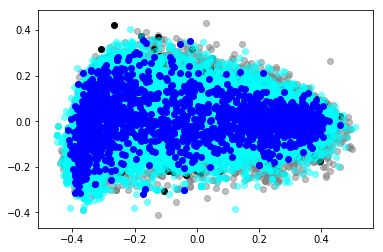

In [ ]:
batch_size=20
optimizer = Adam(lr=0.001)
epochs=10
for epoch_i in range(epochs):
    losses = []
    start = time.time()
    all_positives,all_negatives = get_random_triplets(indices,x_train,y_train)
    
    for i in range(0,len(x_train)-batch_size,batch_size):
        x_train_subset = x_train[i:i+batch_size]
        y_train_subset = y_train[i:i+batch_size]
        neg_subset = all_negatives[i:i+batch_size]
        pos_subset = all_positives[i:i+batch_size]
        batch_loss = train(model,optimizer,x_train_subset,y_train_subset,neg_subset,pos_subset)
        losses.append(float(batch_loss))
        
    # model.save_weights("model")
    took_time = round((time.time()-start)/60,2)
    print("epoch {} loss: {}, took: {} min.".format(epoch_i,round(sum(losses)/len(losses),4),took_time))
    
    y_train_pred,train_emb = model(x_train)
    y_train_pred = y_train_pred.numpy()
    y_train_pred[y_train_pred<0.5]=0
    y_train_pred[y_train_pred>=0.5]=1
    
    y_test_pred,test_emb = model(x_test)
    y_test_pred = y_test_pred.numpy()
    y_test_pred[y_test_pred<0.5]=0
    y_test_pred[y_test_pred>=0.5]=1
    
    model_f1,model_acc,model_bal_acc = round(f1_score(y_test,y_test_pred,average="macro"),4),round(accuracy_score(y_test,y_test_pred),4),round(balanced_accuracy_score(y_test,y_test_pred),4)
    train_model_f1,train_model_acc,train_model_bal_acc = round(f1_score(y_train,y_train_pred,average="macro"),4),round(accuracy_score(y_train,y_train_pred),4),round(balanced_accuracy_score(y_train,y_train_pred),4)
    print("---TEST: f1:{},acc:{},bal_acc:{}; TRAIN: f1:{},acc:{},bal_acc:{}".format(model_f1,model_acc,model_bal_acc,train_model_f1,train_model_acc,train_model_bal_acc))
    plot_pca(train_emb,y_train,test_emb,y_test)